### Import Libraries

In [1]:
import json
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/kchoi22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Loading Function
##### Define a function to load JSON file to DataFrame. Then load in the data.

In [69]:
def load_json_to_df(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return pd.DataFrame.from_dict(data, orient='index')


In [70]:
json_files = ['HR.json', 'HF.json', 'MR.json', 'MF.json', 'PHF.json', 'PHR.json', 'PMF.json', 'PMR.json']
dfs = []

# Load each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df_path = f'data/{json_file}'  
    df = load_json_to_df(df_path)
    dfs.append(df)

HR_df, HF_df, MR_df, MF_df, PHF_df, PHR_df, PMF_df, PMR_df = dfs


In [71]:
import re
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

HR_df['cleaned_text'] = HR_df['text'].apply(clean_text)
HF_df['cleaned_text'] = HF_df['text'].apply(clean_text)
MR_df['cleaned_text'] = MR_df['text'].apply(clean_text)
MF_df['cleaned_text'] = MF_df['text'].apply(clean_text)

In [72]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

HR_df['preprocessed_text'] = HR_df['cleaned_text'].apply(preprocess_text)
HF_df['preprocessed_text'] = HF_df['cleaned_text'].apply(preprocess_text)
MR_df['preprocessed_text'] = MR_df['cleaned_text'].apply(preprocess_text)
MF_df['preprocessed_text'] = MF_df['cleaned_text'].apply(preprocess_text)

In [73]:

from collections import Counter
# Function to load and tokenize the text from a DataFrame
def load_and_tokenize_text(json_file):
    df = load_json_to_df(json_file)
    # Tokenize each item in the 'text' column
    df['tokens'] = df['preprocessed_text'].apply(word_tokenize)
    return df

# List of JSON files
json_files = ['HR_prep.json', 'HF_prep.json', 'MR_prep.json', 'MF_prep.json']
category_data = []

# Load and tokenize each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df = load_and_tokenize_text('data/' + json_file)
    category_data.append(df)

# Extract tokenized words for each category
tokens_hr = [token for sublist in category_data[0]['tokens'] for token in sublist]
tokens_hf = [token for sublist in category_data[1]['tokens'] for token in sublist]
tokens_mr = [token for sublist in category_data[2]['tokens'] for token in sublist]
tokens_mf = [token for sublist in category_data[3]['tokens'] for token in sublist]

def display_common_words(tokens, category_name):
    counter = Counter(tokens)
    most_common = counter.most_common()  # Get the top common words sorted by frequency

    # Exclude the words with frequency over 2000 and under 30
    filtered_common = [(word, freq) for word, freq in most_common if not (freq > 2000 or freq < 30)]
    
    # Create a DataFrame for the filtered common words
    df_filtered_common = pd.DataFrame(filtered_common, columns=['Word', 'Frequency'])
    
    # Count the number of words falling within the specified frequency range
    count_within_range = sum(1 for word, freq in most_common if 30 <= freq <= 2000)
    
#     print(f"Number of words within the frequency range (30 to 2000): {count_within_range}\n")

#     print(f"Common words in {category_name} (excluding words with frequency over 2000 and under 30):")
#     for word, freq in filtered_common:
#         print(f"{word}: {freq}")
#     print("\n")
    
    return df_filtered_common

# Example usage
# display_common_words(tokens_hr, "Human Real")
# display_common_words(tokens_hf, "Human Fake")
# display_common_words(tokens_mr, "Machine Real")
# display_common_words(tokens_mf, "Machine Fake")

# Create DataFrames for each category
df_hr_filtered_common = display_common_words(tokens_hr, "Human Real")
df_hf_filtered_common = display_common_words(tokens_hf, "Human Fake")
df_mr_filtered_common = display_common_words(tokens_mr, "Machine Real")
df_mf_filtered_common = display_common_words(tokens_mf, "Machine Fake")


In [74]:
hr_filtered_words = set(df_hr_filtered_common['Word'])
hf_filtered_words = set(df_hf_filtered_common['Word'])
mr_filtered_words = set(df_mr_filtered_common['Word'])
mf_filtered_words = set(df_mf_filtered_common['Word'])

# Function to filter text
def filter_text(text, filtered_words):
    # Split text into words
    words = text.split()
    # Filter words that are present in filtered_words
    filtered_text = [word for word in words if word in filtered_words]
    # Join the filtered words back into text
    return ' '.join(filtered_text)

# Apply the filter_text function to the 'text' column of HR_df
HR_df['filtered'] = HR_df['text'].apply(lambda x: filter_text(x, hr_filtered_words))
HF_df['filtered'] = HF_df['text'].apply(lambda x: filter_text(x, hf_filtered_words))
MR_df['filtered'] = MR_df['text'].apply(lambda x: filter_text(x, mr_filtered_words))
MF_df['filtered'] = MF_df['text'].apply(lambda x: filter_text(x, mf_filtered_words))

In [38]:

# Function to filter words based on frequency
def filter_frequency(docs, top_p=0.1, bottom_p=0.1):
    # Tokenize words across all documents
    all_words = [word for doc in docs for word in word_tokenize(doc.lower())]  # Lowercase for uniformity
    fdist = FreqDist(all_words)
    
    # Determine cutoffs for top and bottom frequencies
    num_words = len(fdist)
    top_cutoff = int(num_words * top_p)
    bottom_cutoff = int(num_words * bottom_p)
    common_words = {word for word, freq in fdist.most_common(top_cutoff)}
    rare_words = {word for word, freq in fdist.most_common()[:-bottom_cutoff-1:-1]}

    # Filter documents
    filtered_docs = []
    for doc in docs:
        tokens = word_tokenize(doc.lower())
        filtered_tokens = [token for token in tokens if token not in common_words and token not in rare_words]
        filtered_docs.append(' '.join(filtered_tokens))
    return filtered_docs

# Apply filtering to each DataFrame
HR = filter_frequency(HR_df['text'])
HF = filter_frequency(HF_df['text'])
MR = filter_frequency(MR_df['text'])
MF = filter_frequency(MF_df['text'])

### Preprocessing Data

##### The `filter_frequency` function is designed to refine text data by removing words that are either too common or too rare. Specifically, it eliminates the top 10% most frequently occurring words and the bottom 10% least frequently occurring words from the dataset.

#### Why is this important?
- **Removing the most frequent words:** These are typically common words in English, such as "the", "is", and "and", which appear in almost all English texts and are generally not useful for distinguishing between different types of text ).
- **Removing the least frequent words:** These words often appear only a few times in the dataset. They can be unique to specific documents and can lead to overfitting, where a model performs well on its training data but poorly on new, unseen data because it has learned to recognize specific, rare words rather than general patterns.

#### How does it work?
1. **Tokenization and Lowercasing:** Each document is split into individual words (tokens), and all tokens are converted to lowercase to ensure that the same word in different cases is counted as the same word.
2. **Frequency Distribution Calculation:** The function calculates how often each word appears across all documents to understand the overall word usage patterns.
3. **Identify Common and Rare Words:**
   - **Top 10% Most Frequent:** It identifies the top 10% of words that have the highest frequency. These words are considered too common and are set to be removed.
   - **Bottom 10% Least Frequent:** Similarly, it identifies the words that fall into the bottom 10% of frequency. These words are so rare that they might not be useful for learning general patterns.
4. **Filter Out Unwanted Words:** The function then recreates each document, excluding the words identified in the previous step. This results in a filtered version of each document that excludes these extremes.


### Preparing Data for Model Training

- **Combining Texts:** We take texts from two distinct categories (like Human Real and Machine Fake) and concatenate them into a single dataset. For example, `texts_hr_vs_mf` combines texts categorized under 'Human Real' with those under 'Machine Fake'.

- **Purpose of Labels:** These labels are what the model will learn to predict. By training the model on these labels, it learns the characteristics of texts from each category, enabling it to categorize new, unseen texts accurately.

#### What is the purpose of splitting the data?
- **Data Splitting:** The data is split into two parts: one for training the model (`X_train`, `y_train`) and the other for testing its performance (`X_test`, `y_test`).
- **Training Set:** The model learns from this data. It tries to understand the patterns or features that distinguish texts with label 0 from those with label 1.
- **Testing Set:** This set is used to evaluate how well the model has learned. It is crucial that the model performs well on this data because it simulates how the model will perform in real-world scenarios, on data it has never seen before.
- **Test Size 0.2:** This means 20% of the data is kept for testing, and the remaining 80% is used for training. The choice of 20% is a common practice that balances having enough data for both training and validation.

#### Why is this important?
Preparing the data this way helps ensure that our machine learning models are trained in a structured environment and tested on unbiased data. Properly prepared data, along with correctly assigned labels and thoughtful splitting, are foundational to building robust, accurate models. This cell encapsulates the essential preprocessing steps needed before any machine learning can begin, setting the stage for effective model training and validation.


In [75]:
# Combining all texts into a single DataFrame
all_texts = pd.concat([HR_df, HF_df, MR_df, MF_df], ignore_index=True)
all_labels = [0] * len(HR_df) + [1] * len(HF_df) + [0] * len(MR_df) + [1] * len(MF_df)

# Combining human real and fake texts
human_texts = pd.concat([HR_df, HF_df], ignore_index=True)
human_labels = [0] * len(HR_df) + [1] * len(HF_df)

# Combining machine real and fake texts
machine_texts = pd.concat([MR_df, MF_df], ignore_index=True)
machine_labels = [0] * len(MR_df) + [1] * len(MF_df)

# Split each combined dataset
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(all_texts['cleaned_text'], all_labels, test_size=0.2, random_state=42)
X_train_human, X_test_human, y_train_human, y_test_human = train_test_split(human_texts['cleaned_text'], human_labels, test_size=0.2, random_state=42)
X_train_machine, X_test_machine, y_train_machine, y_test_machine = train_test_split(machine_texts['cleaned_text'], machine_labels, test_size=0.2, random_state=42)

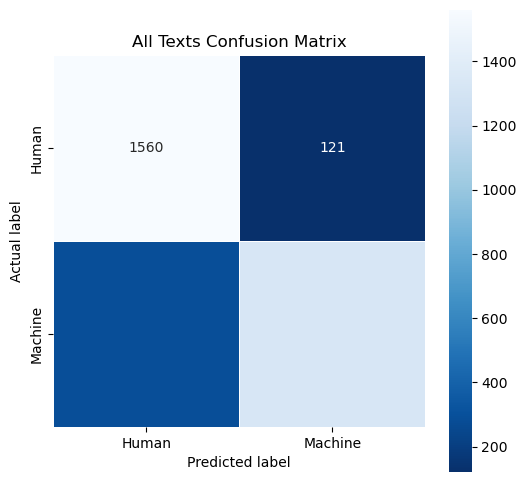

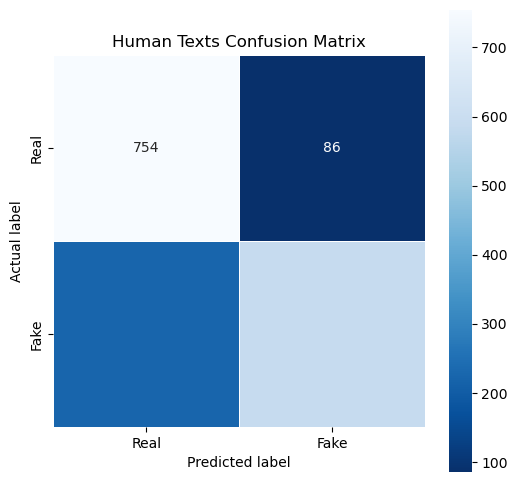

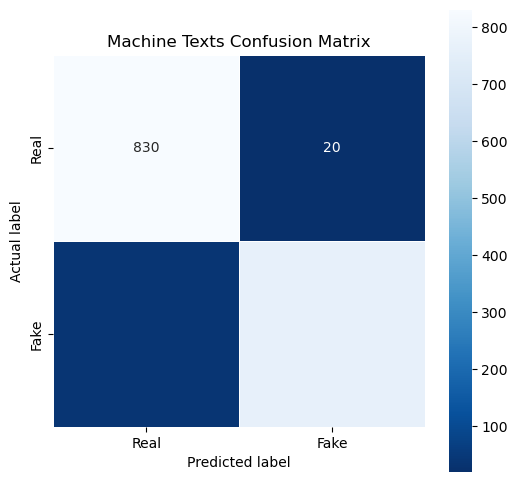

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Adjusted train_svm to return the vectorizer and model
def train_and_predict(X_train, X_test, y_train):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    model = SVC(kernel='linear', C=0.5, random_state=42)
    model.fit(X_train_tfidf, y_train)
    X_test_tfidf = vectorizer.transform(X_test)
    y_pred = model.predict(X_test_tfidf)
    return y_pred, model, vectorizer

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)

# Example: Create and plot confusion matrix for 'All Text'
y_pred_all, model_all, vectorizer_all = train_and_predict(X_train_all, X_test_all, y_train_all)
cm_all = confusion_matrix(y_test_all, y_pred_all)
plot_confusion_matrix(cm_all, ['Human', 'Machine'], 'All Texts Confusion Matrix')

# Repeat for human and machine texts
y_pred_human, model_human, vectorizer_human = train_and_predict(X_train_human, X_test_human, y_train_human)
cm_human = confusion_matrix(y_test_human, y_pred_human)
plot_confusion_matrix(cm_human, ['Real', 'Fake'], 'Human Texts Confusion Matrix')

y_pred_machine, model_machine, vectorizer_machine = train_and_predict(X_train_machine, X_test_machine, y_train_machine)
cm_machine = confusion_matrix(y_test_machine, y_pred_machine)
plot_confusion_matrix(cm_machine, ['Real', 'Fake'], 'Machine Texts Confusion Matrix')

plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def plot_cross_val_scores(X, y, title, n_splits=5):
    # Setup the SVM and vectorizer within a Pipeline
    from sklearn.pipeline import Pipeline
    vectorizer = TfidfVectorizer()
    svm_model = SVC(kernel='linear', C=0.5, random_state=42)
    pipeline = Pipeline([
        ('tfidf', vectorizer),
        ('svm', svm_model)
    ])
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X, y, cv=n_splits, scoring='accuracy')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_splits + 1), scores, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.ylim(0.0, 1.0)
    plt.xticks(range(1, n_splits + 1))
    plt.grid(True)
    plt.show()
    
    return scores

# Assuming X_train_all, y_train_all, X_train_human, y_train_human, etc., are defined
# For All Texts
plot_cross_val_scores(X_train_all, y_train_all, 'Cross-Validation Accuracy for All Texts')

# For Human Texts
plot_cross_val_scores(X_train_human, y_train_human, 'Cross-Validation Accuracy for Human Texts')

# For Machine Texts
plot_cross_val_scores(X_train_machine, y_train_machine, 'Cross-Validation Accuracy for Machine Texts')


In [39]:
# Combine text data for each comparison
texts_hr_vs_mf = pd.concat([pd.Series(HR), pd.Series(MF)], ignore_index=True)
texts_hf_vs_mf = pd.concat([pd.Series(HF), pd.Series(MF)], ignore_index=True)
texts_mr_vs_mf = pd.concat([pd.Series(MR), pd.Series(MF)], ignore_index=True)
texts_hf_vs_mr = pd.concat([pd.Series(HF), pd.Series(MR)], ignore_index=True)
texts_hr_vs_mr = pd.concat([pd.Series(HR), pd.Series(MR)], ignore_index=True)
texts_hr_vs_hf = pd.concat([pd.Series(HR), pd.Series(HF)], ignore_index=True)

# Create labels for each comparison
labels_hr_vs_mf = [0] * len(HR) + [1] * len(MF)
labels_hf_vs_mf = [0] * len(HF) + [1] * len(MF)
labels_mr_vs_mf = [0] * len(MR) + [1] * len(MF)
labels_hf_vs_mr = [0] * len(HF) + [1] * len(MR)
labels_hr_vs_mr = [0] * len(HR) + [1] * len(MR)
labels_hr_vs_hf = [0] * len(HR) + [1] * len(HF)

# Split the data for each comparison
X_train_hr_vs_mf, X_test_hr_vs_mf, y_train_hr_vs_mf, y_test_hr_vs_mf = train_test_split(texts_hr_vs_mf, labels_hr_vs_mf, test_size=0.2, random_state=42)
X_train_hf_vs_mf, X_test_hf_vs_mf, y_train_hf_vs_mf, y_test_hf_vs_mf = train_test_split(texts_hf_vs_mf, labels_hf_vs_mf, test_size=0.2, random_state=42)
X_train_mr_vs_mf, X_test_mr_vs_mf, y_train_mr_vs_mf, y_test_mr_vs_mf = train_test_split(texts_mr_vs_mf, labels_mr_vs_mf, test_size=0.2, random_state=42)
X_train_hf_vs_mr, X_test_hf_vs_mr, y_train_hf_vs_mr, y_test_hf_vs_mr = train_test_split(texts_hf_vs_mr, labels_hf_vs_mr, test_size=0.2, random_state=42)
X_train_hr_vs_mr, X_test_hr_vs_mr, y_train_hr_vs_mr, y_test_hr_vs_mr = train_test_split(texts_hr_vs_mr, labels_hr_vs_mr, test_size=0.2, random_state=42)
X_train_hr_vs_hf, X_test_hr_vs_hf, y_train_hr_vs_hf, y_test_hr_vs_hf = train_test_split(texts_hr_vs_hf, labels_hr_vs_hf, test_size=0.2, random_state=42)

### Training SVM Models

##### Transforming text data into a format suitable for machine learning (using TF-IDF vectorization), training a Support Vector Machine (SVM) model on these data, and evaluating its performance in terms of accuracy. It sets up a systematic approach to apply this process across multiple pairs of text categories.

#### What is TF-IDF Vectorization?
- **TF-IDF Vectorizer**: The `TfidfVectorizer` converts a collection of raw documents into a matrix of TF-IDF features. This is crucial because SVM and most other machine learning algorithms require numerical input rather than raw text.
- **Purpose of TF-IDF**: TF-IDF stands for "Term Frequency-Inverse Document Frequency." This statistic highlights words that are more relevant to a specific document in the dataset, distinguishing them from common words across all documents. It helps the model focus on words that are distinctive and informative.

#### How does the SVM model work here?
- **SVM (Support Vector Machine)**: This is a type of supervised machine learning algorithm which can be used for both classification or regression challenges. Here, it is used to classify texts based on the labels provided.
- **Linear Kernel**: We're using a linear kernel here, which means the SVM will attempt to separate the data using a straight line (or hyperplane in higher dimensions). The parameter `C` controls the margin of the hyperplane and how much the model penalizes misclassified points during training.
- **Model Training**: The model is trained (`model.fit`) on the training dataset transformed by TF-IDF, learning to associate the input features with the target labels.
- **Prediction and Accuracy**: After training, the model's performance is evaluated by predicting labels for the testing set and comparing these predictions against the true labels (`accuracy_score`). Accuracy is a straightforward metric that measures the proportion of correct predictions made by the model.

#### How is the data organized for training and testing?
- **Data Dictionaries**: Four dictionaries (`data_train`, `data_test`, `labels_train`, `labels_test`) are created to organize the training and testing data along with their corresponding labels for each text comparison category like 'HR vs. MF' (Human Real vs. Machine Fake).
- **Loop Over Comparisons**: A loop iterates over each pair of text categories, training an SVM model for each and printing out the accuracy. This structured approach allows us to compare the effectiveness of the model across different types of textual comparisons.

#### Why is this approach useful?
- **Scalability and Flexibility**: By structuring the data and model training this way, we can easily add new text categories or adjust our text processing methods. It makes the model training process both scalable and flexible.
- **Comparative Analysis**: Training separate models for different pairs of text categories allows for a detailed comparative analysis. We can identify which types of texts are more challenging for the model and where it performs well.


In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'C': 0.5}
Best cross-validation score: 0.78


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Function to create a TF-IDF vectorizer and train a model
def train_svm(X_train, X_test, y_train, y_test):
    # Create a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train the SVM model
    model = SVC(kernel='linear', C=0.5, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Predict and calculate accuracy
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Dictionaries to store the training and testing data
data_train = {
    'HR vs MF': X_train_hr_vs_mf,
    'HF vs MF': X_train_hf_vs_mf,
    'MR vs MF': X_train_mr_vs_mf,
    'HF vs MR': X_train_hf_vs_mr,
    'HR vs MR': X_train_hr_vs_mr,
    'HR vs HF': X_train_hr_vs_hf
}

data_test = {
    'HR vs MF': X_test_hr_vs_mf,
    'HF vs MF': X_test_hf_vs_mf,
    'MR vs MF': X_test_mr_vs_mf,
    'HF vs MR': X_test_hf_vs_mr,
    'HR vs MR': X_test_hr_vs_mr,
    'HR vs HF': X_test_hr_vs_hf
}

labels_train = {
    'HR vs MF': y_train_hr_vs_mf,
    'HF vs MF': y_train_hf_vs_mf,
    'MR vs MF': y_train_mr_vs_mf,
    'HF vs MR': y_train_hf_vs_mr,
    'HR vs MR': y_train_hr_vs_mr,
    'HR vs HF': y_train_hr_vs_hf
}

labels_test = {
    'HR vs MF': y_test_hr_vs_mf,
    'HF vs MF': y_test_hf_vs_mf,
    'MR vs MF': y_test_mr_vs_mf,
    'HF vs MR': y_test_hf_vs_mr,
    'HR vs MR': y_test_hr_vs_mr,
    'HR vs HF': y_test_hr_vs_hf
}

# Train the model and print accuracies for each comparison
for comparison in data_train.keys():
    accuracy = train_svm(data_train[comparison], data_test[comparison], labels_train[comparison], labels_test[comparison])
    print(f"Accuracy for {comparison}: {accuracy:.2f}")


Accuracy for HR vs MF: 0.99
Accuracy for HF vs MF: 0.97
Accuracy for MR vs MF: 0.98
Accuracy for HF vs MR: 0.93
Accuracy for HR vs MR: 0.88
Accuracy for HR vs HF: 0.86


In [64]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Function to compute accuracy using cross-validation
def validate_svm(X, y, n_splits=5):
    vectorizer = TfidfVectorizer()
    model = SVC(kernel='linear', C=0.5, random_state=42)
    pipeline = make_pipeline(vectorizer, model)
    
    # Compute cross-validated accuracy
    accuracies = cross_val_score(pipeline, X, y, cv=n_splits, scoring='accuracy')
    return accuracies

# Example usage
for comparison in data_train.keys():
    accuracies = validate_svm(data_train[comparison], labels_train[comparison])
    print(f"Cross-validated accuracies for {comparison}: {accuracies}")
    print(f"Average accuracy for {comparison}: {accuracies.mean():.2f}")


Cross-validated accuracies for HR vs MF: [0.97572079 0.98179059 0.98179059 0.98254932 0.98557327]
Average accuracy for HR vs MF: 0.98
Cross-validated accuracies for HF vs MF: [0.96403979 0.97016067 0.97016067 0.97398623 0.97013783]
Average accuracy for HF vs MF: 0.97
Cross-validated accuracies for MR vs MF: [0.98107494 0.96971991 0.96818182 0.97878788 0.98030303]
Average accuracy for MR vs MF: 0.98
Cross-validated accuracies for HF vs MR: [0.94322483 0.93641181 0.94015152 0.93409091 0.93181818]
Average accuracy for HF vs MR: 0.94
Cross-validated accuracies for HR vs MR: [0.85885886 0.8521021  0.88429752 0.85574756 0.84973704]
Average accuracy for HR vs MR: 0.86
Cross-validated accuracies for HR vs HF: [0.83611533 0.82245827 0.82776935 0.83459788 0.84889901]
Average accuracy for HR vs HF: 0.83


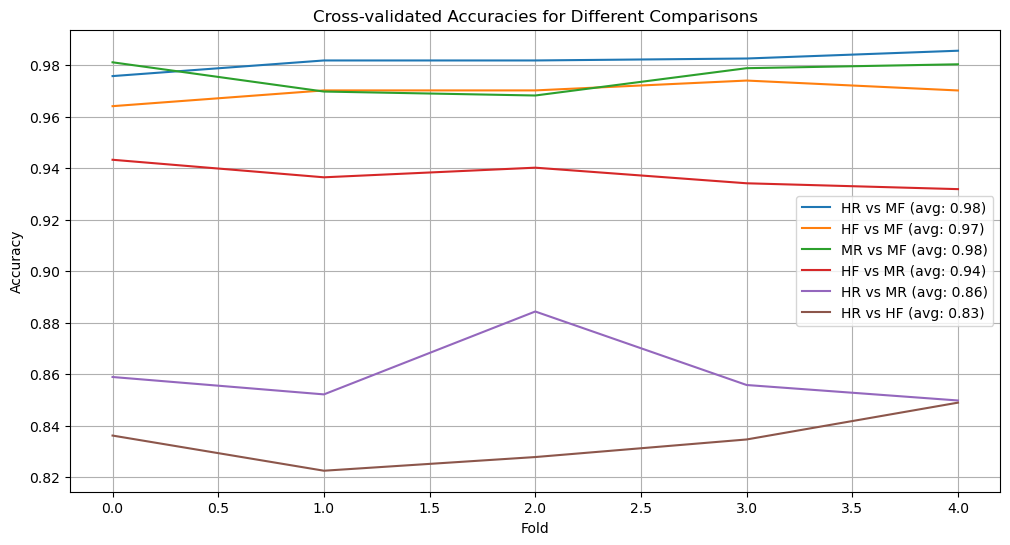

In [65]:
import matplotlib.pyplot as plt

# Plotting function
def plot_accuracies(comparisons, accuracies):
    plt.figure(figsize=(12, 6))
    for comparison, accuracy in zip(comparisons, accuracies):
        plt.plot(accuracy, label=f'{comparison} (avg: {np.mean(accuracy):.2f})')
    
    plt.title('Cross-validated Accuracies for Different Comparisons')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Gather data for plotting
comparison_names = list(data_train.keys())
all_accuracies = [validate_svm(data_train[comparison], labels_train[comparison]) for comparison in comparison_names]

# Plot accuracies
plot_accuracies(comparison_names, all_accuracies)


### Generating a Detailed Classification Report with 
#### Key Metrics Explained
- **Precision**: Indicates the accuracy of positive predictions.
- **Recall**: Measures how well the model identifies actual positives.
- **F1-Score**: Harmonic mean of precision and recall, providing a single score that balances both.
- **Support**: Number of actual occurrences of each class in the test set, indicating data balance.

#### Key Findings: 
- **High Accuracy**: Both classes show nearly perfect precision and recall, suggesting excellent model performance.
- **Consideration**: High metrics may indicate overfitting; ensure the model is tested on completely unseen data and consider validating with additional data sets.



In [16]:
from sklearn.metrics import classification_report

def detailed_classification_report(X_train, X_test, y_train, y_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    model = SVC(kernel='linear', C=0.5, random_state=42)
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    report = classification_report(y_test, y_pred)
    print(report)

# Get a detailed report for HR vs MF
detailed_classification_report(X_train_hr_vs_mf, X_test_hr_vs_mf, y_train_hr_vs_mf, y_test_hr_vs_mf)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       840
           1       0.99      0.98      0.99       808

    accuracy                           0.99      1648
   macro avg       0.99      0.99      0.99      1648
weighted avg       0.99      0.99      0.99      1648



### Cross-Validation: Ensuring Model Robustness

#### Why Cross-Validation?
Cross-validation is crucial for confirming that our SVM models generalize well to new data, beyond a fixed training-test split. It helps ensure that our model's performance is not just a result of overfitting to a particular subset of data.

#### Key Benefits:
- **Reduces Bias**: By rotating the training and test sets, it minimizes the risk that our model's performance is overly dependent on the specific way the data was split.
- **Validates Generalizability**: Provides a more holistic view of how the model performs across the entire dataset.


#### Analysis of Results:
The variation in scores from high (0.99) to relatively lower (0.86) suggests that while the model performs exceptionally well in some comparisons (e.g., HR vs MF), it struggles in others (HR vs HF). This could be due to inherent differences in the difficulty of distinguishing between certain categories, or it might indicate that the model parameters are not optimal for all types of text comparisons. But overall, for all the comparisons the accuracy still stayed pretty high.

In [19]:
from sklearn.model_selection import cross_val_score

def cross_validate_model(X, y):
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(X)

    model = SVC(kernel='linear', C=0.78, random_state=42)
    # Perform 5-fold cross-validation and return the average accuracy
    cv_scores = cross_val_score(model, X_tfidf, y, cv=5)
    return cv_scores.mean()

# Apply cross-validation to each text comparison and print the results
for comparison in data_train.keys():
    cv_accuracy = cross_validate_model(pd.concat([data_train[comparison], data_test[comparison]]),
                                       labels_train[comparison] + labels_test[comparison])
    print(f"Cross-Validation Accuracy for {comparison}: {cv_accuracy:.2f}")


Cross-Validation Accuracy for HR vs MF: 0.99
Cross-Validation Accuracy for HF vs MF: 0.97
Cross-Validation Accuracy for MR vs MF: 0.98
Cross-Validation Accuracy for HF vs MR: 0.94
Cross-Validation Accuracy for HR vs MR: 0.88
Cross-Validation Accuracy for HR vs HF: 0.86


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_svm_with_ngrams(X_train, X_test, y_train, y_test, ngram_range=(1, 2)):
    # Create a TF-IDF Vectorizer that considers n-grams
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Initialize and train the SVM model
    model = SVC(kernel='linear', C=0.5, random_state=42)
    model.fit(X_train_tfidf, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Applying the function to each pair of texts
ngram_accuracies = {}
for comparison in data_train.keys():
    accuracy = train_svm_with_ngrams(
        data_train[comparison], data_test[comparison],
        labels_train[comparison], labels_test[comparison],
        ngram_range=(1, 3)  # You can adjust this to (1,2) for bigrams or (1,3) for trigrams
    )
    ngram_accuracies[comparison] = accuracy

# Print out accuracies with n-grams
for comparison, acc in ngram_accuracies.items():
    print(f"Accuracy for {comparison} with n-grams: {acc:.2f}")


Accuracy for HR vs MF with n-grams: 0.99
Accuracy for HF vs MF with n-grams: 0.96
Accuracy for MR vs MF with n-grams: 0.97
Accuracy for HF vs MR with n-grams: 0.88
Accuracy for HR vs MR with n-grams: 0.80
Accuracy for HR vs HF with n-grams: 0.83


In [42]:
# Labeling the data
PHR_df['label'] = 0  # Real
PHF_df['label'] = 1  # Fake

# Assuming similar labeling is needed for machine-generated dataframes
PMR_df['label'] = 0  # Real
PMF_df['label'] = 1  # Fake


In [43]:
# Assuming PHR_df, PHF_df, PMR_df, and PMF_df are already loaded and available
# Prepare combined datasets for each type of comparison

# Combine all human-generated texts (real vs. fake)
human_texts = pd.concat([PHR_df, PHF_df])
human_labels = [0] * len(PHR_df) + [1] * len(PHF_df)  # 0 for real, 1 for fake

# Combine all machine-generated texts (real vs. fake)
machine_texts = pd.concat([PMR_df, PMF_df])
machine_labels = [0] * len(PMR_df) + [1] * len(PMF_df)  # 0 for real, 1 for fake


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to vectorize text
def vectorize_text(texts):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Using bi-grams
    return vectorizer.fit_transform(texts), vectorizer

# Vectorize human and machine texts
X_human, vectorizer_human = vectorize_text(human_texts['text'])
X_machine, vectorizer_machine = vectorize_text(machine_texts['text'])


In [45]:
from sklearn.model_selection import train_test_split

# Split human data
X_train_human, X_test_human, y_train_human, y_test_human = train_test_split(X_human, human_labels, test_size=0.2, random_state=42)

# Split machine data
X_train_machine, X_test_machine, y_train_machine, y_test_machine = train_test_split(X_machine, machine_labels, test_size=0.2, random_state=42)


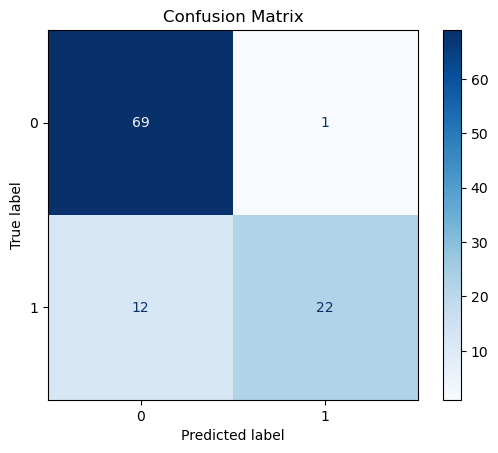

All Texts (Human vs. Machine) Evaluation:
Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91        70
           1       0.96      0.65      0.77        34

    accuracy                           0.88       104
   macro avg       0.90      0.82      0.84       104
weighted avg       0.89      0.88      0.87       104



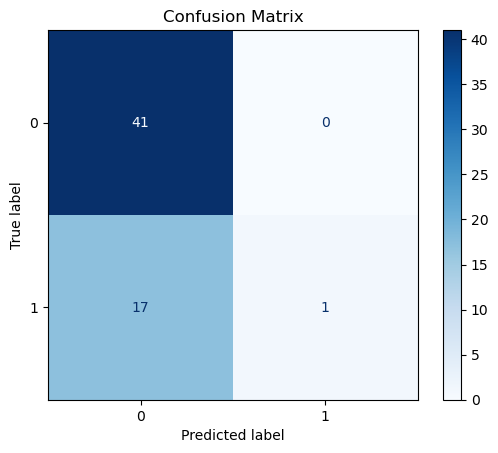

Human Real vs. Fake Evaluation:
Accuracy: 0.711864406779661
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        41
           1       1.00      0.06      0.11        18

    accuracy                           0.71        59
   macro avg       0.85      0.53      0.47        59
weighted avg       0.80      0.71      0.61        59



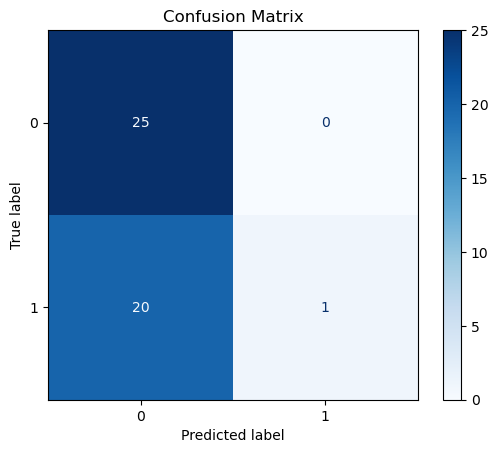

Machine Real vs. Fake Evaluation:
Accuracy: 0.5652173913043478
Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71        25
           1       1.00      0.05      0.09        21

    accuracy                           0.57        46
   macro avg       0.78      0.52      0.40        46
weighted avg       0.76      0.57      0.43        46



In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Label the datasets
PHR_df['label'] = 0  # Real human
PHF_df['label'] = 1  # Fake human
PMR_df['label'] = 0  # Real machine
PMF_df['label'] = 1  # Fake machine

# Combine datasets for each comparison
all_human_df = pd.concat([PHR_df, PHF_df])
all_machine_df = pd.concat([PMR_df, PMF_df])

all_texts_df = pd.concat([all_human_df, all_machine_df])  # All texts, human and machine

# Vectorize the data
def vectorize_data(data):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    features = vectorizer.fit_transform(data['text'])
    return features, vectorizer

# Vectorize all data
X_all, vectorizer_all = vectorize_data(all_texts_df)
y_all = all_texts_df['label']

# Vectorize human data
X_human, vectorizer_human = vectorize_data(all_human_df)
y_human = all_human_df['label']

# Vectorize machine data
X_machine, vectorizer_machine = vectorize_data(all_machine_df)
y_machine = all_machine_df['label']

def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = SVC(kernel='linear', C=0.5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report

# Split data and evaluate
def prepare_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    accuracy, report = train_and_evaluate(X_train, X_test, y_train, y_test)
    return accuracy, report

# Evaluate all texts (human vs. machine)
accuracy_all, report_all = prepare_and_evaluate(X_all, y_all)
print("All Texts (Human vs. Machine) Evaluation:")
print("Accuracy:", accuracy_all)
print("Classification Report:\n", report_all)

# Evaluate human real vs. fake
accuracy_human, report_human = prepare_and_evaluate(X_human, y_human)
print("Human Real vs. Fake Evaluation:")
print("Accuracy:", accuracy_human)
print("Classification Report:\n", report_human)

# Evaluate machine real vs. fake
accuracy_machine, report_machine = prepare_and_evaluate(X_machine, y_machine)
print("Machine Real vs. Fake Evaluation:")
print("Accuracy:", accuracy_machine)
print("Classification Report:\n", report_machine)



In [58]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

def cross_validate_model_with_scores(X, y, cv_folds=10, n_jobs=1):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(X)
    model = SVC(kernel='linear', C=0.78, random_state=42)
    scores = cross_val_score(model, X_tfidf, y, cv=cv_folds, n_jobs=n_jobs)
    return scores

# Test with n_jobs=1 to debug
scores_all = cross_validate_model_with_scores(all_texts_df['text'], all_texts_df['label'], n_jobs=1)
print(scores_all)


[0.88461538 0.88461538 0.91346154 0.93269231 0.95192308]


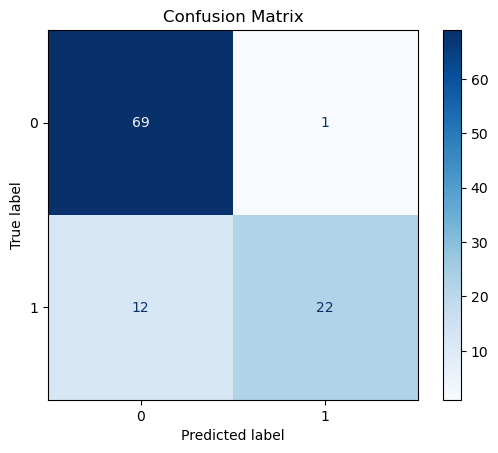

All Texts (Human vs. Machine) Evaluation:
Accuracy: 0.875
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91        70
           1       0.96      0.65      0.77        34

    accuracy                           0.88       104
   macro avg       0.90      0.82      0.84       104
weighted avg       0.89      0.88      0.87       104



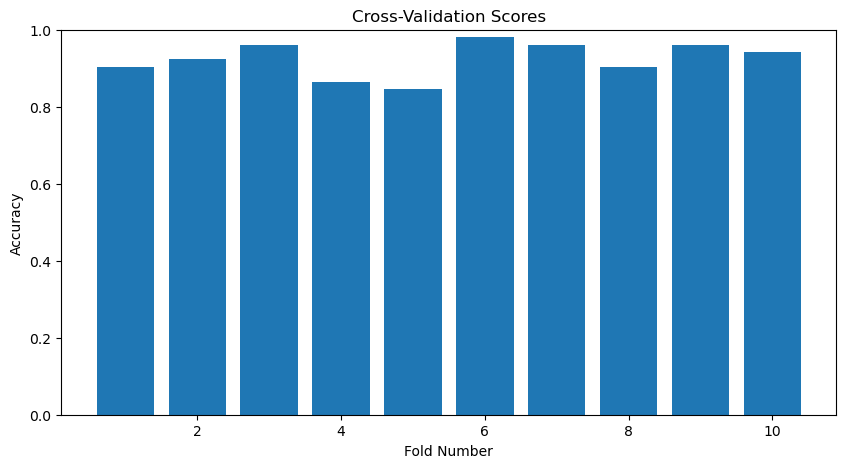

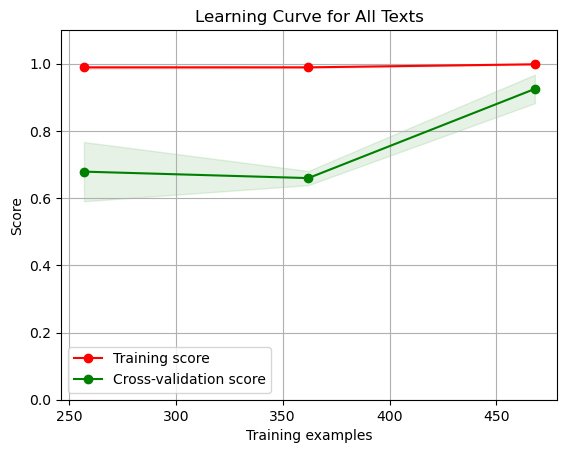

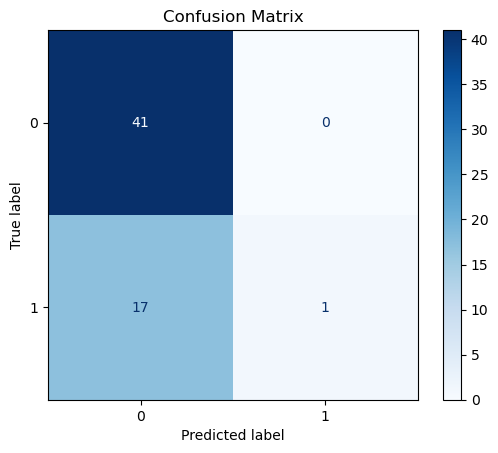

Human Real vs. Fake Evaluation:
Accuracy: 0.711864406779661
Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83        41
           1       1.00      0.06      0.11        18

    accuracy                           0.71        59
   macro avg       0.85      0.53      0.47        59
weighted avg       0.80      0.71      0.61        59



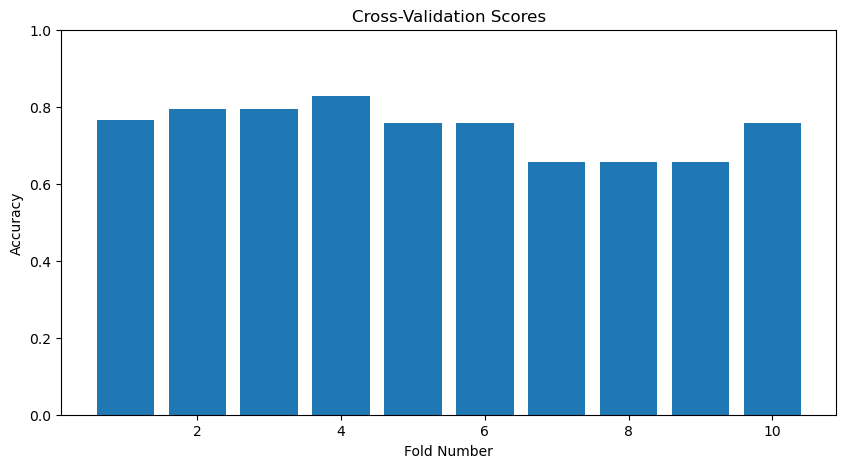

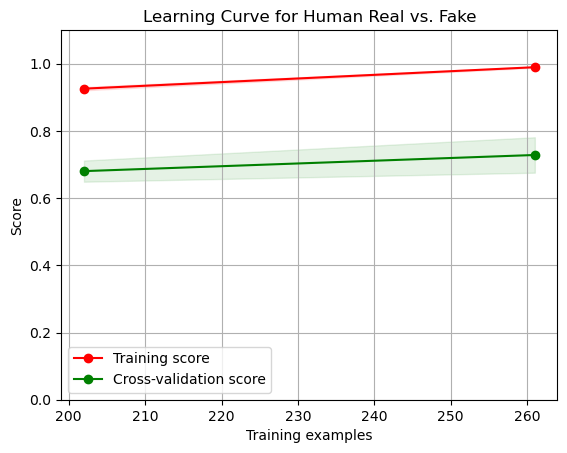

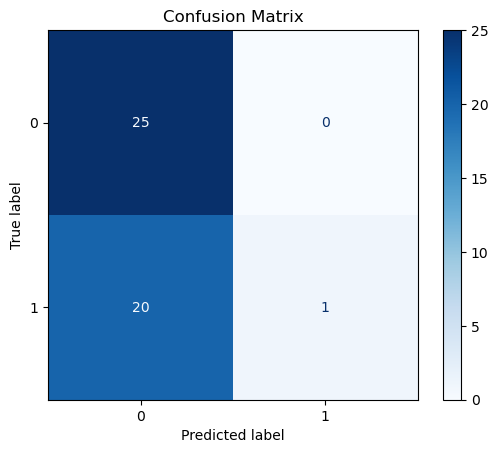

Machine Real vs. Fake Evaluation:
Accuracy: 0.5652173913043478
Classification Report:
               precision    recall  f1-score   support

           0       0.56      1.00      0.71        25
           1       1.00      0.05      0.09        21

    accuracy                           0.57        46
   macro avg       0.78      0.52      0.40        46
weighted avg       0.76      0.57      0.43        46



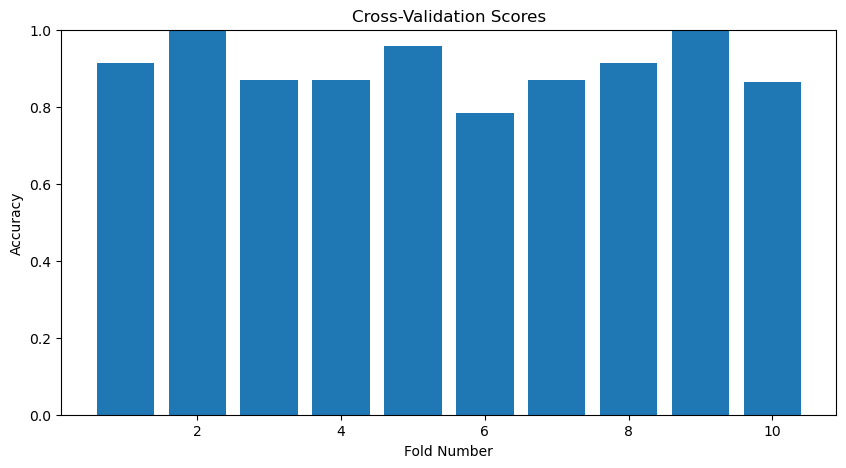

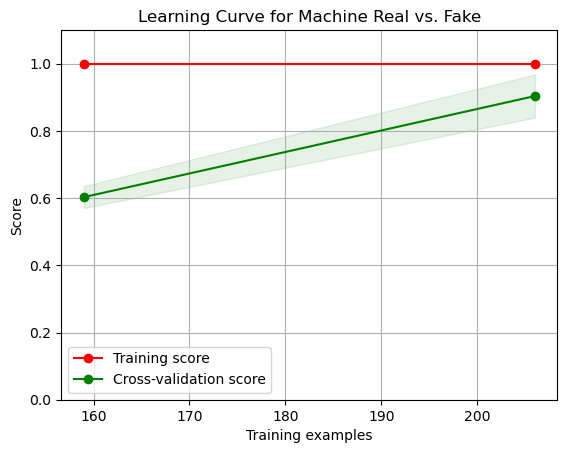

In [63]:
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Existing functions (train_and_evaluate, prepare_and_evaluate) are assumed to be already defined as per your input.

# Function to plot cross-validation scores
def plot_cross_validation_scores(X, y, model, cv=10):
    cv_scores = cross_val_score(model, X, y, cv=cv)
    plt.figure(figsize=(10, 5))
    plt.title('Cross-Validation Scores')
    plt.bar(range(1, cv+1), cv_scores)
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()
    return cv_scores

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Assuming X_all, y_all, etc. are already defined and vectorized
model = SVC(kernel='linear', C=0.78)

accuracy_all, report_all = prepare_and_evaluate(X_all, y_all)
print("All Texts (Human vs. Machine) Evaluation:")
print("Accuracy:", accuracy_all)
print("Classification Report:\n", report_all)

# Plot Cross-Validation Scores
plot_cross_validation_scores(X_all, y_all, model)

# Plot Learning Curve
plot_learning_curve(model, "Learning Curve for All Texts", X_all, y_all, cv=10)


# Evaluate Human Real vs. Fake
accuracy_human, report_human = prepare_and_evaluate(X_human, y_human)
print("Human Real vs. Fake Evaluation:")
print("Accuracy:", accuracy_human)
print("Classification Report:\n", report_human)

# Plot Cross-Validation Scores for Human Data
plot_cross_validation_scores(X_human, y_human, model)

# Plot Learning Curve for Human Data
plot_learning_curve(model, "Learning Curve for Human Real vs. Fake", X_human, y_human, cv=10)

# Evaluate Machine Real vs. Fake
accuracy_machine, report_machine = prepare_and_evaluate(X_machine, y_machine)
print("Machine Real vs. Fake Evaluation:")
print("Accuracy:", accuracy_machine)
print("Classification Report:\n", report_machine)

# Plot Cross-Validation Scores for Machine Data
plot_cross_validation_scores(X_machine, y_machine, model)

# Plot Learning Curve for Machine Data
plot_learning_curve(model, "Learning Curve for Machine Real vs. Fake", X_machine, y_machine, cv=10)



NameError: name 'tfidf_vectorizer_human_machine' is not defined

In [1]:
import json
import numpy as np
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import nltk


# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/kchoi22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kchoi22/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kchoi22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kchoi22/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Function to load JSON data into a DataFrame
def load_json_to_df(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return pd.DataFrame.from_dict(data, orient='index')

# List of JSON files
json_files = ['HR_prep.json', 'HF_prep.json', 'MR_prep.json', 'MF_prep.json', 'PHF.json', 'PHR.json', 'PMF.json', 'PMR.json']
dfs = []

# Load each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df_path = f'data/{json_file}'  # Corrected file path string formation
    df = load_json_to_df(df_path)
    dfs.append(df)

# Naming the DataFrames, ensure you have all 8 DataFrames named if using them distinctly
HR_df, HF_df, MR_df, MF_df, PHF_df, PHR_df, PMF_df, PMR_df = dfs

In [3]:
HR = HR_df['preprocessed_text']
HF = HF_df['preprocessed_text']
MR = MR_df['preprocessed_text']
MF = MF_df['preprocessed_text']

# Extracting 'text' columns for PolitiFact datasets
PHR = PHR_df['text']
PHF = PHF_df['text']
PMR = PMR_df['text']
PMF = PMF_df['text']

In [4]:
df = pd.concat([HR, HF, MR, MF], ignore_index=True)

In [5]:
from nltk import FreqDist
from collections import Counter

# Function to load and tokenize the text from a DataFrame
def load_and_tokenize_text(json_file):
    df = load_json_to_df(json_file)
    # Tokenize each item in the 'text' column
    df['tokens'] = df['preprocessed_text'].apply(word_tokenize)
    return df

# List of JSON files
json_files = ['HR_prep.json', 'HF_prep.json', 'MR_prep.json', 'MF_prep.json']
category_data = []

# Load and tokenize each JSON file into a DataFrame and store them in a list
for json_file in json_files:
    df = load_and_tokenize_text('data/' + json_file)
    category_data.append(df)

# Extract tokenized words for each category
tokens_hr = [token for sublist in category_data[0]['tokens'] for token in sublist]
tokens_hf = [token for sublist in category_data[1]['tokens'] for token in sublist]
tokens_mr = [token for sublist in category_data[2]['tokens'] for token in sublist]
tokens_mf = [token for sublist in category_data[3]['tokens'] for token in sublist]

# Function to display common words within a specific frequency range
def display_common_words(tokens, category_name, min_freq, max_freq):
    # Calculate frequencies of words
    freq_dist = FreqDist(tokens)

    # Filter words within the frequency range and sort by frequency
    filtered_words = {word: count for word, count in freq_dist.items() if min_freq <= count <= max_freq}
    sorted_filtered_words = dict(sorted(filtered_words.items(), key=lambda item: item[1], reverse=True))

In [6]:
from nltk import FreqDist

# Combine all tokens from each dataset
all_tokens = tokens_hr + tokens_hf + tokens_mr + tokens_mf

# Calculate the frequency distribution of all tokens
freq_dist = FreqDist(all_tokens)

# Filter tokens by frequency range
filtered_tokens = {word for word, count in freq_dist.items() if 100 <= count <= 2000}

In [7]:
def filter_text(text, filtered_vocab):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Filter tokens based on the frequency-filtered vocabulary
    filtered_text = ' '.join([token for token in tokens if token in filtered_vocab])
    return ' '.join(filtered_text)

In [9]:
# Add a 'label' column to PHR_df
PHR_df['label'] = 0  # Real

# Add a 'label' column to PHF_df
PHF_df['label'] = 1  # Fake

PMR_df['label'] = 0 # Machine Real

PMF_df['label'] = 1 # Machine Fake

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(text)  # Tokenize the cleaned text
    filtered_text = ' '.join([word for word in tokens if word not in stop_words])
    return filtered_text

# Apply the function and store results as a clean text string
for df in [PHR_df, PHF_df, PMF_df, PMR_df]:
    df['text_clean'] = df['text'].apply(remove_stopwords)


# Apply this function to your PolitiFact DataFrames
PHR_df['text_clean'] = PHR_df['text'].apply(remove_stopwords)
PHF_df['text_clean'] = PHF_df['text'].apply(remove_stopwords)
PMF_df['text_clean'] = PMF_df['text'].apply(remove_stopwords)
PMR_df['text_clean'] = PMR_df['text'].apply(remove_stopwords)


df_human = pd.concat([PHR_df, PHF_df], ignore_index=True)
df_machine = pd.concat([PMR_df, PMF_df], ignore_index=True)

all_combine =pd.concat([df_human,df_machine], ignore_index=True)

df_human['label'] = 0  # Human-generated
df_machine['label'] = 1  # Machine-generated

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=30000)

# Assuming you have some original training data to fit the vectorizer; here we use 'all_combine' for demonstration
tfidf_vectorizer.fit(all_combine['text_clean'])

# Transform the datasets
X_human = tfidf_vectorizer.transform(df_human['text_clean'])
X_machine = tfidf_vectorizer.transform(df_machine['text_clean'])



In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming svm_hr_vs_hf and svm_mr_vs_mf are the trained models for human and machine texts respectively

# Predictions for Human Real vs. Human Fake
y_pred_hr_vs_hf = svm_hr_vs_hf.predict(X_human)
accuracy_hr_vs_hf = accuracy_score(df_human['label'], y_pred_hr_vs_hf)
print("Accuracy for Human Real vs. Human Fake:", accuracy_hr_vs_hf)

# Predictions for Machine Real vs. Machine Fake
y_pred_mr_vs_mf = svm_mr_vs_mf.predict(X_machine)
accuracy_mr_vs_mf = accuracy_score(df_machine['label'], y_pred_mr_vs_mf)
print("Accuracy for Machine Real vs. Machine Fake:", accuracy_mr_vs_mf)

# Plotting confusion matrices
plot_confusion_matrix(svm_hr_vs_hf, X_human, df_human['label'], display_labels=['Human Real', 'Human Fake'])
plt.show()

plot_confusion_matrix(svm_mr_vs_mf, X_machine, df_machine['label'], display_labels=['Machine Real', 'Machine Fake'])
plt.show()


NameError: name 'svm_hr_vs_hf' is not defined